In [3]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from shapely import geometry
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [5]:
# read RoofPV_capacity data for year 2050 under SSP2 scenario
RoofPV_capacity_path='E:/UM2024/PVDegradationTools-main/RoofPV_capacity_potential_ssp2_2050_modi.nc'
RoofPV_capacity=xr.open_dataarray(RoofPV_capacity_path)



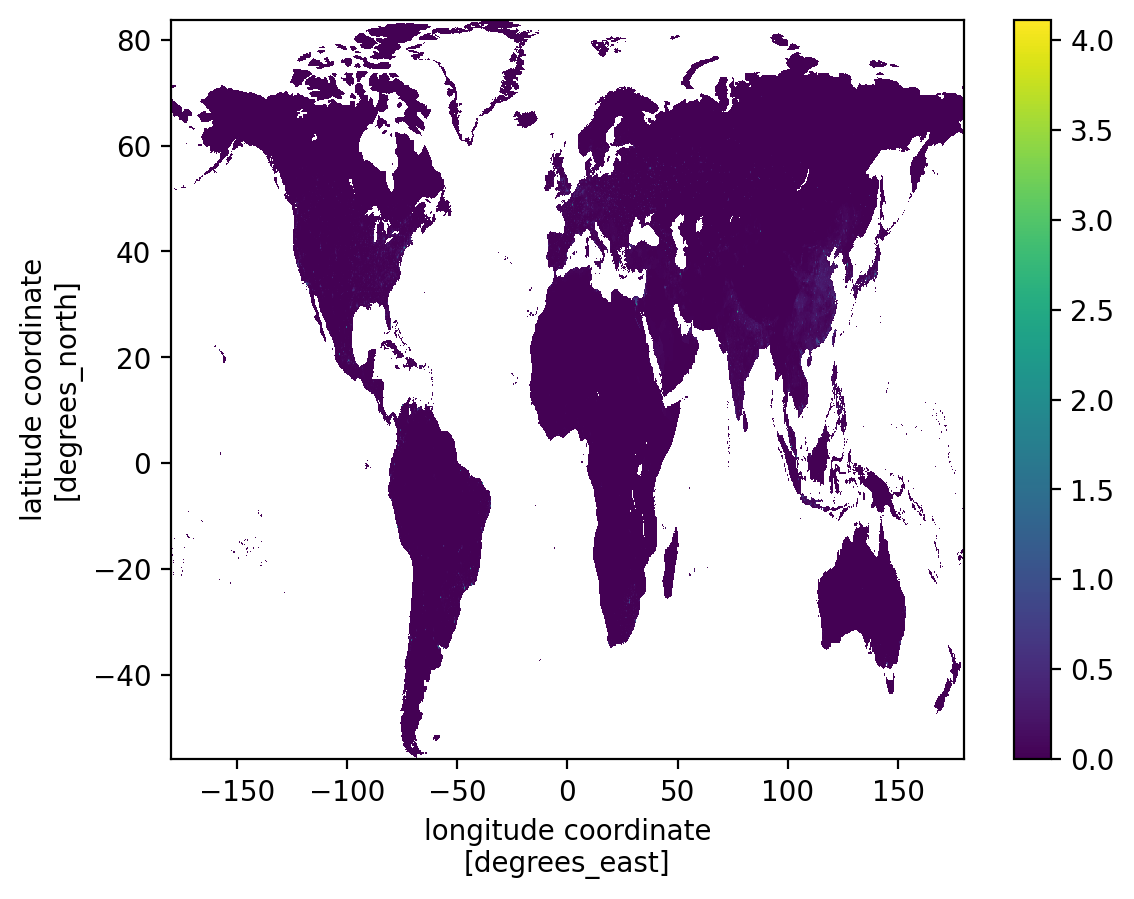

In [7]:
RoofPV_capacity.plot()

In [9]:
# define colormap1
color1=np.array([
    [225,225,225],
    [255, 245, 204],
    [255, 230, 112],
    [255, 204,  51],
    [255, 175,  51],
    [255, 153,  51],
    [255, 111,  51],
    [255,  85,   0],
    [230,  40,  30],
    [200,  30,  20]])
cmap1=mpl.colors.ListedColormap(color1/255.)

# define colormap2
color2=np.array([
    [255,255,229],
    [255,247,188],
    [254,227,145],
    [254,196,79],
    [254,153,41],
    [236,112,20],
    [204,76,2],
    [153,52,4],
    [119.,42.,5.33333333],
    [103,0,31],
    [201,148,199]
])
cmap2=mpl.colors.ListedColormap(color2/255.)

In [10]:
# define region lat-lon ranges

# South Asia
SAS={'lat1':7,
   'lat2':35,
   'lon1':63,
   'lon2':95}

# East Asia
EAS={'lat1':7,
   'lat2':56,
   'lon1':100,
   'lon2':137}

# West Africa
WAF={'lat1':-3,
   'lat2':25,
   'lon1':-15,
   'lon2':30}

# Middle East
ME={'lat1':8,
   'lat2':36,
   'lon1':35,
   'lon2':60}

# North America
NAM={'lat1':10,
   'lat2':48,
   'lon1':-120,
   'lon2':-77}
regions=[SAS,EAS,WAF,ME,NAM]

In [57]:
# add boxes representing certain regions
def add_sub_region_box(ax, subregion):
    geom = geometry.box(minx=subregion['lon1'],maxx=subregion['lon2'],miny=subregion['lat1'],maxy=subregion['lat2'])
    center_lat=(subregion['lat1']+subregion['lat2'])/2
    center_lon=(subregion['lon1']+subregion['lon2'])/2
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      facecolor ='none',edgecolor='k',linewidth=0.5)
    return ax

# subplot to make each individual map
def subplot(data,axis,norm,cmap,LON,LAT,landmask,dointerp,add_region):
    if dointerp:
        g=axis.pcolormesh(LON, LAT,data.pipe(interp).where(landmask==0),
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,norm=norm,rasterized=True) 
    else:
        g=axis.pcolormesh(LON, LAT,data.where(landmask==0),
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,norm=norm,rasterized=True) 
    if add_region:
        for region in regions:
            add_sub_region_box(axis, region)
    axis.coastlines(linewidth=0.5,resolution='50m') # add coastlines
    axis.set_title('')
    axis.set_extent([-169.999,189.999,-60,75]) # set extent of the map to exclude high latitudes
    return g

# curve plot
def curve(x,y,axis,c,linestyle,label,marker,linewidth):
    g=axis.plot(x,y,color=c,linestyle=linestyle,label=label,marker=marker,linewidth=linewidth)
    return g

def plot(data,pop,person_many_hours):
    fig = plt.figure(figsize=[12,10])
    levels2=[0,500,1000,5000,10000,20000,40000,60000,80000,100000,400000]
    levels2 = [x * 1e-6 for x in levels2]
    norm2=mpl.colors.BoundaryNorm(levels2,ncolors=len(levels2),extend='max')
    clabel2='Rooftop PV Capacity Potential($MW$)'
    
    LON2,LAT2=np.meshgrid(pop.lon.values,pop.lat.values)
    landmask2= regionmask.defined_regions.natural_earth.land_110.mask(pop,lon_name="lon",lat_name="lat")
    
    Xs=[1.5,2,3,4]
    anno_opts = dict(xy=(0, 1.05), xycoords='axes fraction',va='baseline', ha='left')
    annots=['a','b','c','d','e','f']
    
    gs_top = plt.GridSpec(3, 2, top=0.95,hspace=-0.3,wspace=0.05)
    gs_base = plt.GridSpec(5, 4,width_ratios=[2.38,0,1.9,0.1],height_ratios=[4,4,1,2.8,0.2],hspace=0,wspace=0.15)

    ax1 = fig.add_subplot(gs_top[0,0],projection=ccrs.Robinson(central_longitude=10))
    ax2 = fig.add_subplot(gs_top[0,1],projection=ccrs.Robinson(central_longitude=10))
    ax3 = fig.add_subplot(gs_top[1,0],projection=ccrs.Robinson(central_longitude=10))
    ax4 = fig.add_subplot(gs_top[1,1], projection=ccrs.Robinson(central_longitude=10))
    ax5 = fig.add_subplot(gs_base[8:17], projection=ccrs.Robinson(central_longitude=10))
    ax6 = fig.add_subplot(gs_base[14])
    
             
    
    h=subplot(pop,ax5,norm2,cmap2,LON2,LAT2,landmask2,False,False)
    ax5.annotate('e', **anno_opts,fontsize=16)
    
    
    cb2=fig.colorbar(h,ax=ax5,orientation='horizontal',pad=0.04,shrink=0.9,fraction=.08,aspect=50,ticks=levels2)
    cb2.set_label(label=clabel2, size=14)
    cb2.ax.tick_params(labelsize=12)
        # 添加陆地、海岸线和边界
    ax5.add_feature(cfeature.LAND)
    ax5.add_feature(cfeature.COASTLINE)
    ax5.add_feature(cfeature.BORDERS,linestyle=':')
    # cb2.ax.set_xticklabels([x * 1e-2 for x in ['0','0.05','0.1','0.5','1','2','4','6','8','10','40']]) 
    cb2.ax.set_xticklabels([0.0, 0.5, 1, 5, 10, 20, 40, 60, 80, 100, 400])


In [49]:
([float(x) * 1e1 for x in ['0','0.05','0.1','0.5','1','2','4','6','8','10','40']])

[0.0, 0.5, 1.0, 5.0, 10.0, 20.0, 40.0, 60.0, 80.0, 100.0, 400.0]

e:\software\Anaconda\envs\pvdeg\lib\site-packages\regionmask\core\mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


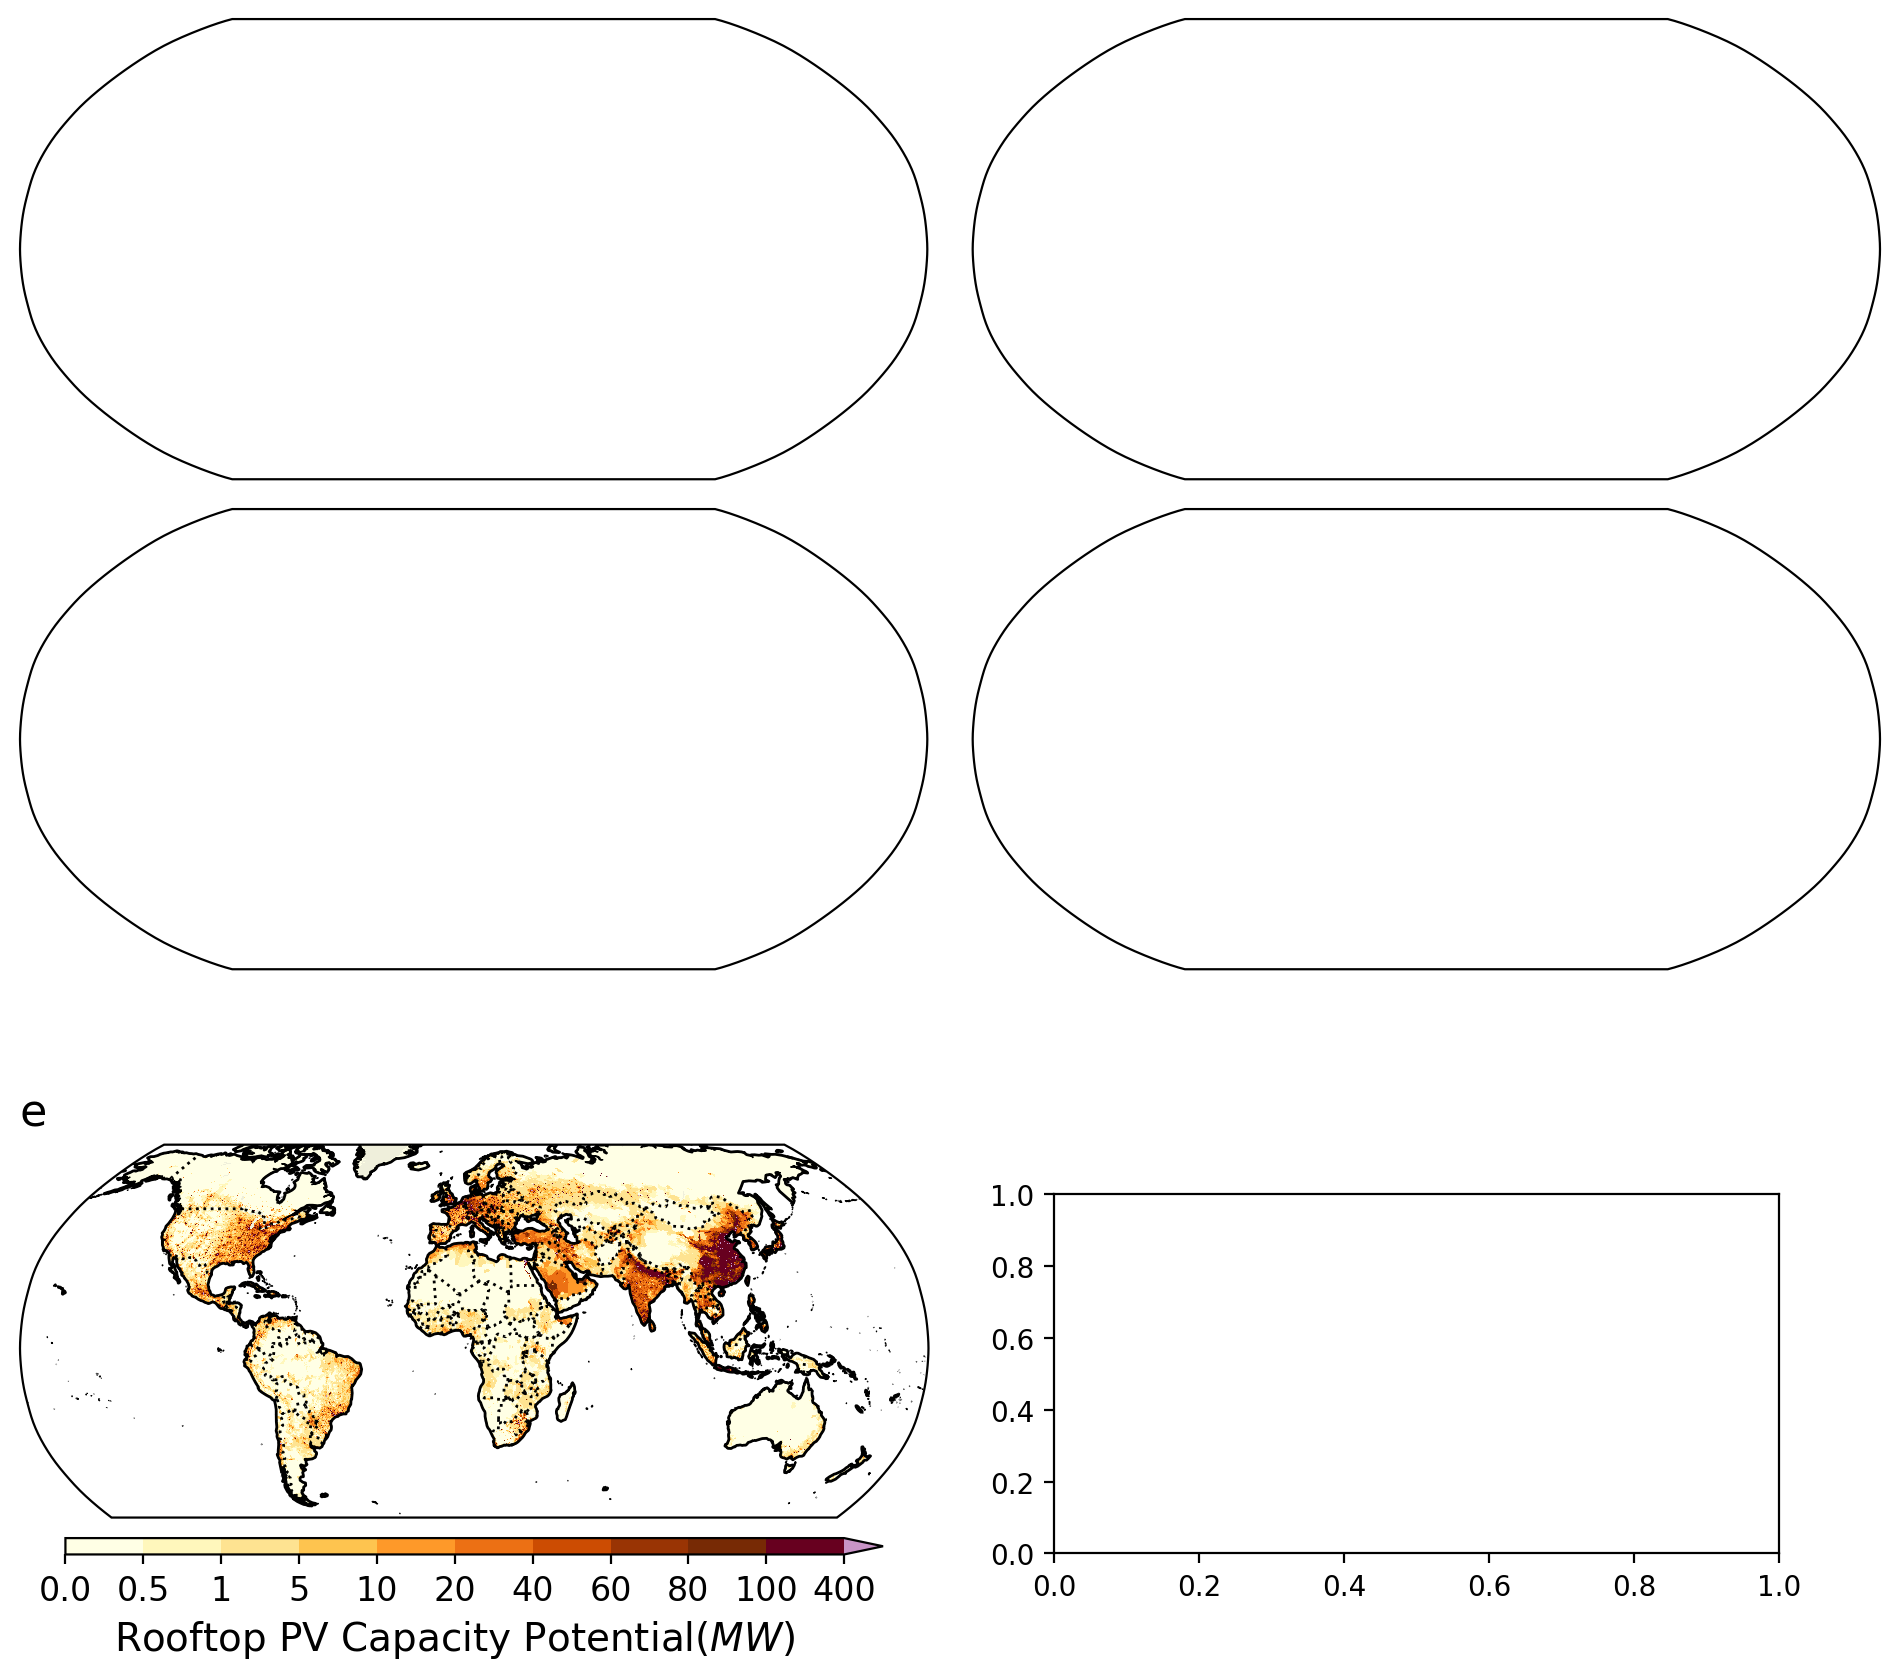

In [58]:
plot(1,RoofPV_capacity,1)